In [608]:
%load_ext autoreload
%autoreload 2
import itertools
import datetime
import os

import pandas as pd
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
import ipywidgets as widgets

import wallstreet as ws
import optionlib as opt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Wallstreet Module Testing

### Vol testing

In [202]:
import statsmodels.api as sm

In [203]:
spy = ws.Stock('^GSPC')
df = spy.historical(1800)
vix = ws.Stock('^VIX')
vix_df = vix.historical(1800)

In [ ]:
vix_df = (vix_df
        .assign(dt=pd.to_datetime(vix_df.Date))
        .set_index('dt')
        )

spy_df = (df
        .assign(vol=df.Close.pct_change().add(1).apply(np.log).rolling(10).std()*np.sqrt(252),
                dt=pd.to_datetime(df.Date),
                lag1=df.Close.shift(1),
                const=1,
                ret=df.Close.pct_change())
        .dropna()
        .set_index('dt')
        )

In [ ]:
fig, axes = plt.subplots(2,1,sharex=True,figsize=(12,8))
axes[0].plot(spy_df.index,spy_df.Close)
axes[1].plot(spy_df.index,spy_df.vol,color='orange')
axes[1].twinx().plot(vix_df.index,vix_df.Close,color='black',alpha=0.5)

In [ ]:
model = sm.OLS(spy_df.Close,spy_df[['const','lag1','vol']]).fit()
model.summary()

In [ ]:
spy_df.vol.mean()

### Bond Testing

In [ ]:
def bond_val(face,coupon,yld,mat,freq=1):
    periods = mat*freq
    pv_face = face/(1+yld)**mat
    coupon = coupon*face
    pv_coup = sum((coupon/freq)/(1+(yld/freq))**i for i in range(1,periods+1))
    return pv_coup + pv_face
    

In [ ]:
bond_val(100,0.09,0.08,20,2)

In [ ]:
def bond_value(face,coupon,yield_,maturity,freq):
    if isinstance(maturity,str):
        maturity = datetime.datetime.strptime(maturity,'%m-%d-%Y')
        now = datetime.datetime.today()
        dt = maturity - now
        periods = np.ceil(dt.days/(365/freq))
    else:
        periods = np.ceil(maturity*freq)
    coupon_ = face*(coupon)
    discounted_coupon = coupon_*(1 - (1+yield_)**-periods)/yield_
    discounted_face = face/(1+yield_)**periods
    return discounted_coupon + discounted_face

In [ ]:
bond_value(100,0.09,0.08,20,2)

In [ ]:
yields = np.linspace(-0.02,0.05,1000)

In [ ]:
plt.plot(yields,bond_value(100,0.05,yields,'01-01-2032',2)
)

### Vol Surface

In [168]:
spy_surf = opt.VolSurface('SPY',moneyness=True)

### Option Testing

In [39]:
bs_call = opt.BSOption(110,100,1,0.3,0.04,'call')
bs_call

+1 BSOption(s=110, k=100, t=1, sigma=0.3, r=0.04, type=C)

In [40]:
bs_call.summary()

parameters       characteristics / greeks           
                                                      
0          S   110                    price  20.417611
1          K   100                    delta   0.725226
2         IV   0.3                    gamma   0.010107
3          t     1                     vega   0.366891
4          r  0.04                    theta  -0.021578
5                                       rho   0.593110

In [41]:
c = opt.MCOption(110, 100,1,0.3,0.04,N=1,M=1e6,type='C',control='all')

In [45]:
vals = [c.value() for i in range(100)]

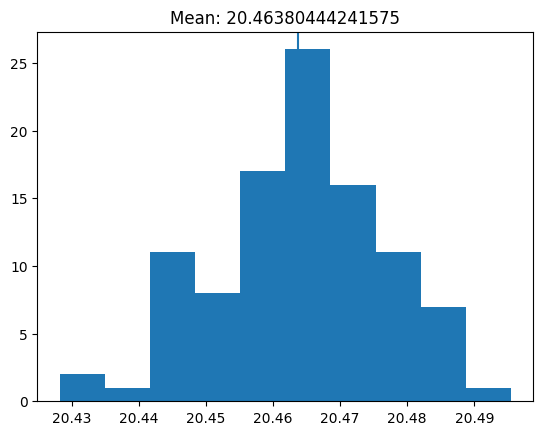

In [46]:
plt.hist(vals,bins=10)
# plt.axvline(bs_call.value())
plt.axvline(np.mean(vals))
plt.title('Mean: {}'.format(np.mean(vals)))
plt.show()

In [29]:
digi = opt.DigitalOption(100,80,1,0.3,0.04,type='C')
ki_put = opt.BarrierOption(100,100,1,0.3,0.04,type='P',barrier=80,barrier_type='KI',M=5e5,N=1,control='all',method='mc')

In [42]:
ki_put.value()

7.204843965745043

In [23]:
ki_put.value()

7.221975263937238

In [78]:
phoenix = (ki_put - digi*10)
phoenix

OptionPortfolio(
+1 BarrierOption(s=100, k=100, t=1, sigma=0.3, r=0.04, barrier=80, barrier_type=KI, type=P, method=mc)
-10 DigitalOption(s=100, k=80, t=1, sigma=0.3, r=0.04, type=C)
)

In [102]:
call1 = opt.BSOption(100, 100,1,0.3,0.04,type='c')
call1.value()

13.716350342434069

In [90]:
call = opt.BinomialOption(100,100,'01-20-2023',0.3,0.04,type='c',n=500,style='E')
call.value()

4.860836502870799

In [6]:
call1 = opt.BSOption(110, 100,'01-20-2023',0.248,0.04,type='c')
put1 = opt.BSOption(110, 90,'01-20-2023',0.248,0.04,type='p')
p = call1 - put1

In [309]:
hedge = opt.DeltaHedge()

In [310]:
p = call1 + hedge

### Monte-Carlo

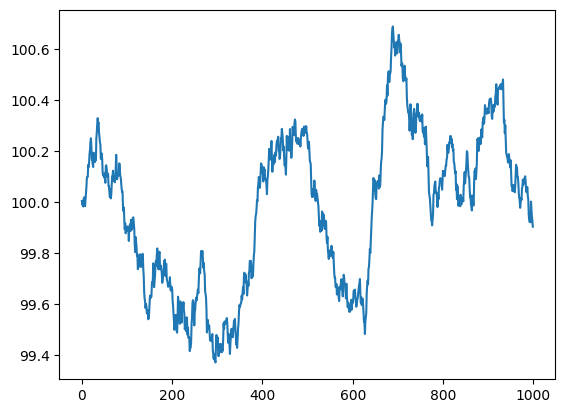

In [14]:
# a function that models a wiener process with stochastic volatility
def wiener_process(t, n, x0=0):
    dt = t/n
    return np.cumsum(np.sqrt(dt)*np.random.randn(n)) + x0

plt.plot(wiener_process(1,1000,100))

In [24]:
c = opt.BinomialOption(s=100,k=100,t=1,r=.05,sigma=.2,n=2000,type_='C',style='A',pos='l',qty=1)

In [109]:
vs = opt.VolSurface('SPY',source='CBOE')

In [288]:
a = np.array([1,2,3,4])

In [289]:
np.append(a, [5,3])

array([1, 2, 3, 4, 5, 3])

In [424]:
digi = opt.DigitalOption(100,80,1,0.3,0.04,'P')
call = opt.BSOption(100,80,1,0.3,0.04,'P')
barrier = call + (20*digi)

In [425]:
barrier.summary()

parameters                          characteristics / greeks          
             Leg 1 (+1P) Leg 2 (+20P)                                   
0      value    2.749227     4.507016               total cost  7.256243
1          S  100.000000   100.000000                    delta -0.349482
2          K   80.000000    80.000000                    gamma  0.014585
3         IV    0.300000     0.300000                     vega  0.437554
4          t    1.000000     1.000000                    theta -0.013360
5          r    0.040000     0.040000                      rho -0.421715

In [531]:
class BarrierOption(opt.OptionPortfolio):

    def __init__(self, s, k, t, sigma, r, type, barrier, barrier_type='KI'):
        spread = abs(barrier - k)
        coeff = 1 if barrier_type == 'KI' else -1
        self.components = [
            opt.BSOption(s, barrier, t, sigma, r, type, qty=1),
            opt.DigitalOption(s, barrier, t, sigma, r, type)*(spread*coeff)
            ]
        if barrier_type == 'KO':
            self.components[0] = opt.BSOption(s, k, t, sigma, r, type, qty=1)
            self.components.append(opt.BSOption(s, barrier, t, sigma, r, type, qty=-1))
        super().__init__(*self.components)
        self.ks.append(k)

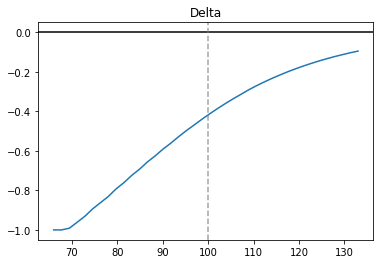

In [5]:
bb = opt.BinomialBarrierOption(
    s=100,
    k=100,
    t=1,
    sigma=0.3,
    r=0.04,
    type='P',
    barrier=80,
    barrier_type='KI',
    n=500
)
bb.summary()

In [549]:
bb.value()

9.231650098473205

In [532]:
barrier = BarrierOption(100,100.,1,0.3,0.04,'P',80,'KI')
barrier.summary()

parameters                            characteristics / greeks          
             Leg 1 (+1P) Leg 2 (+20.0P)                                   
0      value    2.749227       4.507016               total cost  7.256243
1          S  100.000000     100.000000                    delta -0.349482
2          K   80.000000      80.000000                    gamma  0.014585
3         IV    0.300000       0.300000                     vega  0.437554
4          t    1.000000       1.000000                    theta -0.013360
5          r    0.040000       0.040000                      rho -0.421715

In [542]:
barrier.plot('theta',interactive=True)

interactive(children=(FloatSlider(value=2.0, description='t', max=2.0, min=0.001, step=0.01), Output(layout=La…

In [533]:
b = opt.BarrierOption(100,100,0.1,0.3,0.04,'P',1,'mc',80,'KI',N=1,M=3e5,control='antithetic')

In [534]:
b.value()

0.21228379380087334

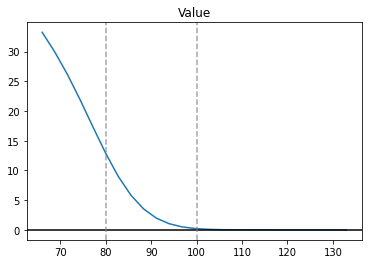

In [466]:
b.plot('value')

In [412]:
mc = opt.MCOption(100,100,1,0.3,0.04,'C',N=252,M=1)
mc.simulate()
path = mc.paths


In [413]:
T = np.linspace(1,0,253)
put = opt.BSOption(100,100,1,0.3,0.04,'P')
sigmas = np.random.normal(0.3,0.01,253)

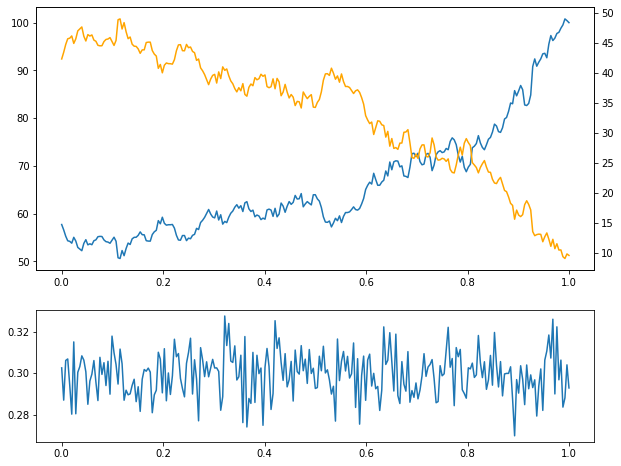

In [414]:

fig, ax = plt.subplots(2,1,figsize=(10,8),gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(T,path)
ax[0].twinx().plot(T,put.value(t=T,s=path,sigma=sigmas),color='orange')
ax[1].plot(T,sigmas)

In [1056]:
b1 = opt.BinomialOption(
    s=100,
    k=100,
    t=0.03,
    sigma=0.3,
    r=0.04,
    type='C',
    n=100,
    style='E'
)

b2 = opt.BSOption(
    s=100,
    k=100,
    t=1,
    sigma=0.3,
    r=0.04,
    type='C',
)

In [1057]:
%%time
b1.value()

Wall time: 0 ns


2.1256668857078047

In [423]:
u = 0.99
d = 1/u
n = 3

In [424]:
def create_tree(u,d,s,n):
    tree = np.zeros((n+1,n+1))
    tree[0,0] = s
    for i in range(1,n+1):
        tree[i,0] = tree[i-1,0]*u
        tree[i,1:] = tree[i-1,:-1]*d
    return tree
    
def value_nodes(tree,pi,r_hat):
    val_tree = np.zeros_like(tree)
    val_tree[0,:] = np.maximum(tree[-1,:]-100,0)
    val_tree[1,:-1] = (1/r_hat)*((pi*val_tree[0,1:])+(1-pi)*val_tree[0,:-1])
    for i in range(2,vals.shape[0]):
        val_tree[i,:-i] = (1/r_hat)*((pi*val_tree[i-1,1:-i+1])+(1-pi)*val_tree[i-1,:-i])

    
    return val_tree

In [392]:
tree = create_tree(u,d,100,n)

In [393]:
value_nodes(tree,0.5,1.01)

2
[[0.         0.         1.01010101 3.06101521]
 [0.         0.50005001 2.01540407 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
3
[[0.         0.         1.01010101 3.06101521]
 [0.         0.50005001 2.01540407 0.        ]
 [0.24754951 1.24527429 0.         0.        ]
 [0.         0.         0.         0.        ]]


array([[0.        , 0.        , 1.01010101, 3.06101521],
       [0.        , 0.50005001, 2.01540407, 0.        ],
       [0.24754951, 1.24527429, 0.        , 0.        ],
       [0.73902168, 0.        , 0.        , 0.        ]])

In [250]:
r_hat = 1.005
pi = 0.51

In [256]:
vals = value_nodes(tree,0.5,1.01)


    print(i)
    print(vals)

1
[[0.         0.         1.01010101 3.06101521]
 [0.         0.51258857 2.04583806 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
2
[[0.         0.         1.01010101 3.06101521]
 [0.         0.51258857 2.04583806 0.        ]
 [1.03818648 0.24991881 0.         0.        ]
 [0.         0.         0.         0.        ]]
3
[[0.         0.         1.01010101 3.06101521]
 [0.         0.51258857 2.04583806 0.        ]
 [1.03818648 0.24991881 0.         0.        ]
 [0.50618047 0.         0.         0.        ]]


In [201]:
vals[2,:-2] = (1/r_hat)*((pi*vals[1,1:-1])+(1-pi)*vals[1,0:-2])

In [75]:
vals = np.maximum(0, tree[-1]-100)

In [83]:
len(vals)

5

In [215]:
((pi*vals[1:]) + ((1-pi)*vals[:-1]))*(1/r_hat)

array([[0.        , 0.        , 0.49248706, 1.49243528],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])